In [1]:
import numpy as np

from load_test_data import load_cSAXS_data, load_downsampled_cSAXS_data
from llama.api.options.projections import ProjectionOptions
from llama.api.options.task import AlignmentTaskOptions
from llama.task import LaminographyAlignmentTask
from llama.projections import ComplexProjections, PhaseProjections
from llama.api.options.reconstruct import ReconstructOptions

import llama.image_processing as ip
from llama.plotting import plotters
import llama.gpu_utils as gutils
from llama.api.options.device import GPUOptions, DeviceOptions
from llama.api.enums import DeviceType
from llama.api.types import r_type, c_type
from llama.io import save, load
import llama.test_utils as tutils
import llama.gpu_utils as gutils

import os

import matplotlib.pyplot as plt
reconstruction_colormap = "bone"

gutils.turn_off_fft_cache()

## First analysis chunk
- Initialization
- Cross correlation alignment
- Mask calculation
- Phase unwrapping

### Initialize data

In [2]:
complex_projections, angles, weights = load_cSAXS_data(load_weights=True)
# complex_projections, angles = load_downsampled_cSAXS_data(8)

In [3]:
projection_options = ProjectionOptions()
complex_projections = ComplexProjections(complex_projections, angles, projection_options)
complex_projections.pin_projections()
complex_projections.masks = weights

task_options = AlignmentTaskOptions()
task = LaminographyAlignmentTask(task_options, complex_projections=complex_projections)

### Get cross-correlation shift

In [4]:
from llama.api.options.device import GPUOptions
from llama.api.enums import DeviceType
task_options.cross_correlation.iterations = 10
task_options.cross_correlation.device.device_type=DeviceType.GPU
n_gpus = 1
task_options.cross_correlation.device.gpu = GPUOptions(
    chunking_enabled=True,
    chunk_length=20,
    n_gpus=n_gpus,
    gpu_indices=[i for i in range(n_gpus)],
)

crop_range = 32 * 30
# crop_range = 128
task_options.cross_correlation.crop_options.enabled = True
task_options.cross_correlation.crop_options.horizontal_range = crop_range
task_options.cross_correlation.crop_options.vertical_range = crop_range

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Cross-correlation shift stored in shift_manager


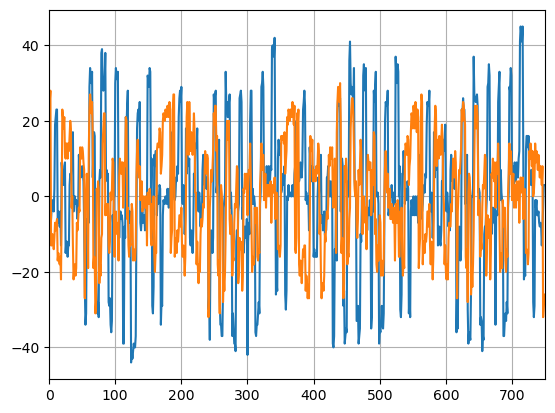

TypeError: ShiftManager.apply_staged_shift() missing 2 required positional arguments: 'device_options' and 'pinned_results'

In [5]:
task.get_cross_correlation_shift()
plt.plot(task.complex_projections.shift_manager.staged_shift[np.argsort(angles)])
plt.grid()
plt.xlim([0, len(angles)])
plt.show()
task.complex_projections.apply_staged_shift()

### Get Mask

#### TBD

In [ ]:
# task.get_complex_projection_masks(enable_plotting=True)

In [ ]:
# plotters.make_image_slider_plot(complex_projections.masks)

#### Blur mask

In [ ]:
# This should be absorbed into the mask creation later. Also, in mask creation
# there should be an option to run the algorithm on just a few projections at
# a time.
blurred_masks = task.complex_projections.blur_masks(kernel_sigma=64, use_gpu=True)
complex_projections.masks = blurred_masks

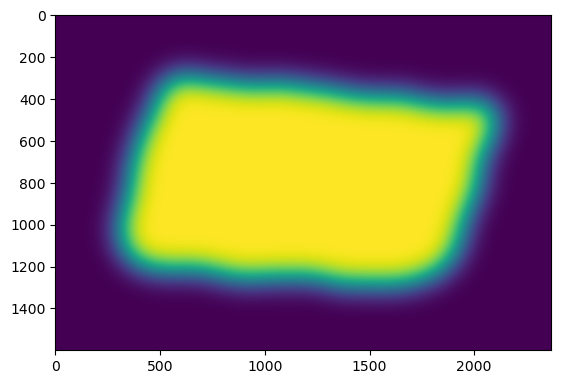

In [ ]:
plt.imshow(blurred_masks[0])
plt.show()

### Phase unwrapping

In [ ]:
# Update settings
complex_projections.options.phase_unwrap.device.device_type=DeviceType.GPU
n_gpus = 1
complex_projections.options.phase_unwrap.device.gpu = GPUOptions(
    chunking_enabled=True,
    chunk_length=20,
    n_gpus=n_gpus,
    gpu_indices=[i for i in range(n_gpus)],
)

# Pin the array holding outputs
pinned_phase_projections = np.empty_like(complex_projections.data, dtype=r_type)
pinned_phase_projections = gutils.pin_memory(pinned_phase_projections)

In [ ]:
# Unwrap the complex projections
task.get_unwrapped_phase(pinned_phase_projections)

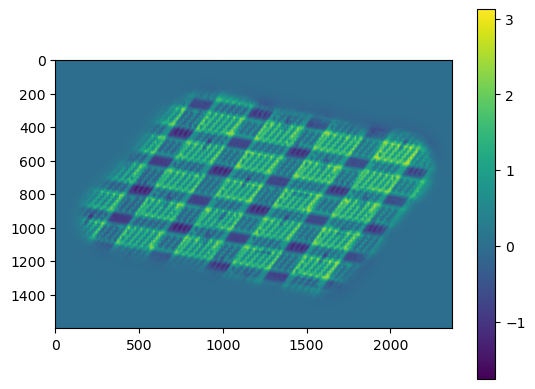

In [ ]:
plt.imshow(task.phase_projections.data[10])
plt.colorbar()
plt.show()

### Save results

In [ ]:
folder = "/local/hruth/lamino_demo_intermediate_results/"
commit_hash = "3a4bd4a"
file_path = os.path.join(folder, "task_" + commit_hash + ".h5")
save.save_task(task, file_path, exclude="complex_projections")

## Chunk 2: 
- Load data
- Projection matching

In [2]:
file_name = "task_3a4bd4a_downsampled_4x.h5"
n_iterations = 3
chunk_length = 20

def load_input_task() -> LaminographyAlignmentTask:
    scale = 4
    task = tutils.load_task(file_name)

    task.phase_projections.data = gutils.pin_memory(task.phase_projections.data)
    task.phase_projections.masks = gutils.pin_memory(task.phase_projections.masks)
    task.phase_projections.options.experiment.pixel_size = 2.74671658e-08 * scale
    task.phase_projections.options.experiment.tilt_angle = 0
    task.phase_projections.options.experiment.skew_angle = 0

    return task


def use_all_gpus_for_astra(reconstruct_options: ReconstructOptions):
    gpu_indices = gutils.get_available_gpus()
    reconstruct_options.astra.forward_project_gpu_indices = gpu_indices
    reconstruct_options.astra.back_project_gpu_indices = (0,)


### Projection matching alignment

In [3]:
from llama.api.enums import DownsampleType


task = load_input_task()

# PMA settings
n_iterations = 30
task.options.projection_matching.iterations = n_iterations
task.options.projection_matching.downsample.enabled = False
task.options.projection_matching.downsample.scale = 1
task.options.projection_matching.downsample.type = DownsampleType.LINEAR

# Device settings
task.options.projection_matching.keep_on_gpu = True
parent_gpu_settings = DeviceOptions(
    device_type=DeviceType.GPU,
    gpu=GPUOptions(chunking_enabled=True, chunk_length=chunk_length),
)
task.options.projection_matching.device = parent_gpu_settings
task.options.projection_matching.reconstruct.filter.device = parent_gpu_settings
use_all_gpus_for_astra(task.options.projection_matching.reconstruct)

task.get_projection_matching_shift()
shift = task.phase_projections.shift_manager.staged_shift

Running function 'Downsampler.run'...
Function 'Downsampler.run': 0.0000 seconds
Running function 'Downsampler.run'...
Function 'Downsampler.run': 0.0000 seconds
Running function 'Downsampler.run'...
Function 'Downsampler.run': 0.0000 seconds
Running function 'Downsampler.run'...
Function 'Downsampler.run': 0.0000 seconds
Running function 'initialize_attributes'...
Function 'initialize_attributes': 0.1370 seconds
Iteration:  0
Running function 'iterate'...
     Running function 'apply_new_shift'...
     Function 'apply_new_shift': 0.0000 seconds
     Running function 'filter_sinogram'...
     Function 'filter_sinogram': 0.2111 seconds
     Running function 'get_3D_reconstruction'...
     Function 'get_3D_reconstruction': 0.3377 seconds
     Running function 'get_forward_projection'...
     Function 'get_forward_projection': 4.3350 seconds
     Running function 'get_shift_update'...
     Function 'get_shift_update': 3.1106 seconds
Function 'iterate': 9.4798 seconds
Iteration:  1
Running

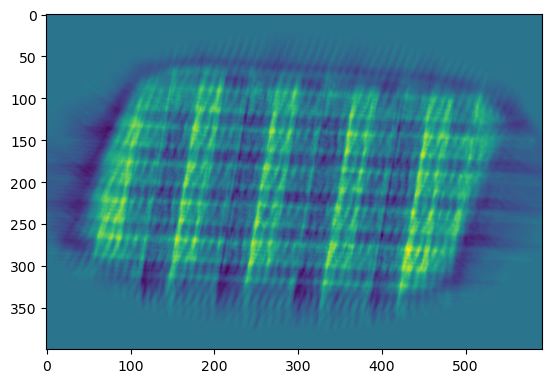

In [4]:
plt.imshow(task.pma_object.aligned_projections.laminogram.model_forward_projections.data[0])

In [19]:
from IPython.display import clear_output
for i in range(100):
    # plt.imshow(task.pma_object.aligned_projections.data[i])
    # plt.imshow(task.phase_projections.data[i] * (255-task.phase_projections.masks[i]))
    plt.imshow(task.pma_object.aligned_projections.laminogram.model_forward_projections.data[i])
    # plt.clim([0, 3])
    plt.show()
    clear_output(wait=True)

KeyboardInterrupt: 

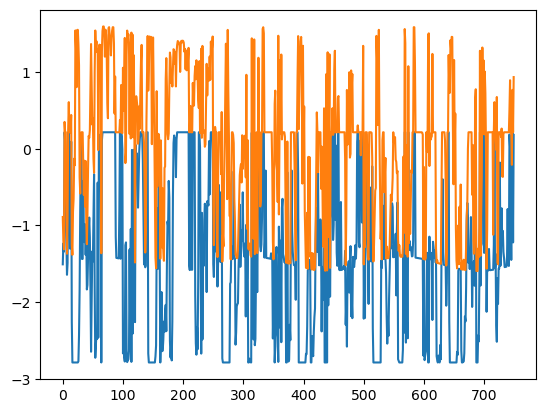

In [5]:
plt.plot(np.sort(task.pma_object.total_shift))